In [1]:
# plotting libraries
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from matplotlib2tikz import save as tikz_save
# numpy (math) libary
import numpy as np

In [2]:
### import PARAMETERS and CONSTANTS
from modules.ConstantsAndParameters import *

### import UTILITY functions
from modules.utils import *

#print_const()
#print_const(normalized=True)

### import model's EQUATIONS
from modules.model import *

### import iterator
from modules.iterate import *

In [3]:
error = 1e-8
maxit = 2e3
history_weight = 0.2

ω_res = 64/3.48*c0/R/f0
print('ω_res = %.5f PHz'%ω_res)
λ_res = f2w(ω_res/(2*np.pi)*f0)/L0
print('λ_res = %.3f nm'%(λ_res*1e3))

ω_size = 9
#ω_range  = 2*np.pi*np.linspace(w2f(1.55035e-6), w2f(1.55055e-6), ω_size)/f0 # [Hz/ω0]
ω_range  = 2*np.pi*np.linspace(w2f(1e-6*λ_res+.5e-9), w2f(1e-6*λ_res+.7e-9), ω_size)/f0 # [Hz/ω0]
print(ω_range)
print()

I_size = 64
P_range = np.linspace(1, 25, num=I_size, endpoint=True) # [10^x mW/mW]
I_range = P_range/ñwga # [10^x mW/mW]
#I_range = np.linspace(10**-2/ñwga, 10**-1/ñwga, num=I_size, endpoint=True) # [10^x mW/mW]
print(I_range)

ω_res = 1.22521 PHz
λ_res = 1537.417 nm
[1.22480711 1.22478721 1.2247673  1.22474739 1.22472748 1.22470758
 1.22468767 1.22466776 1.22464785]

[ 10.          13.80952381  17.61904762  21.42857143  25.23809524
  29.04761905  32.85714286  36.66666667  40.47619048  44.28571429
  48.0952381   51.9047619   55.71428571  59.52380952  63.33333333
  67.14285714  70.95238095  74.76190476  78.57142857  82.38095238
  86.19047619  90.          93.80952381  97.61904762 101.42857143
 105.23809524 109.04761905 112.85714286 116.66666667 120.47619048
 124.28571429 128.0952381  131.9047619  135.71428571 139.52380952
 143.33333333 147.14285714 150.95238095 154.76190476 158.57142857
 162.38095238 166.19047619 170.         173.80952381 177.61904762
 181.42857143 185.23809524 189.04761905 192.85714286 196.66666667
 200.47619048 204.28571429 208.0952381  211.9047619  215.71428571
 219.52380952 223.33333333 227.14285714 230.95238095 234.76190476
 238.57142857 242.38095238 246.19047619 250.        ]


In [4]:
print('history weight %.2f'%history_weight)
print("Completion\tλ\t\t\tmax it\tmax error")
                       
verbose = True
loops = True

### generate empty data storage
u = {} # way up
u['EF']  = np.nan*np.zeros((ω_size, I_size, int(maxit)), dtype=float)
u['I']   = np.nan*np.zeros((ω_size, I_size, int(maxit)), dtype=float)
u['ΔN']  = np.nan*np.zeros((ω_size, I_size, int(maxit)), dtype=float)
u['ΔT']  = np.nan*np.zeros((ω_size, I_size, int(maxit)), dtype=float)
u['Δn']  = np.nan*np.zeros((ω_size, I_size, int(maxit)), dtype=float)
u['Δ𝛾']  = np.nan*np.zeros((ω_size, I_size, int(maxit)), dtype=float)
u['it']  = np.nan*np.zeros((ω_size, I_size), dtype=float)

### two nested for loops, in input power and in
for ω_i in range(ω_size):
        
    for I_i in range(I_size):
        # parameters
        # pωs1, pIs1, pκ, p𝛾, p𝛾TH, p𝛾FC, pMCpV, pn0, pn2, pdndT, pdndN, pdαdN, pβtpa, pV, pR = par
        ñparams = (ω_range[ω_i], I_range[I_i], κ, 𝛾, ñ𝛾TH,  1.0, ñMCpV, ñn0, 0.0, ñdndT, 0.0, 0.0, 0.0, ñV, ñR)
        #ñparams = (ω_range[ω_i], I_range[I_i], κ, 𝛾, ñ𝛾TH, ñ𝛾FC, ñMCpV, ñn0, ñn2, ñdndT, ñdndN, ñdαdN, ñβtpa, ñV, ñR)
        
        ### generate initial condition, set to zero ("cold resonance") at first
        #oxEF, oxI, oxΔN, oxΔT, oxΔn, oxΔ𝛾 = var
        if I_i == 0:
            x0 = (0.0, 0.0, 0.0, 0.0, 0.0, 1.0)
        else: # pick the exit condition of ω_n as initial condition for ω_{n+1}
            x0 = (u['EF'][ω_i,I_i-1,0], u['I'][ω_i,I_i-1,0], u['ΔN'][ω_i,I_i-1,0], u['ΔT'][ω_i,I_i-1,0], u['Δn'][ω_i,I_i-1,0], u['Δ𝛾'][ω_i,I_i-1,0])
            
        ### iterator(variables, parameters, system_to_solve = ñequations, type = 0, max_it, err_it, weight = 0):
        new_var, max_iter = iterator(x0, ñparams, norm_single_source, 2, error, maxit, history_weight)
                
        #if new_var.shape[0] < history:
        #    new_var = np.vstack([ np.nan*np.zeros((history-new_var.shape[0],new_var.shape[1])), new_var ])
        
        u['EF'][ω_i,I_i,:max_iter]   = new_var[::-1, 0]
        u['I'][ω_i,I_i,:max_iter]   = new_var[::-1, 1]
        u['ΔN'][ω_i,I_i,:max_iter]   = new_var[::-1, 2]
        u['ΔT'][ω_i,I_i,:max_iter]   = new_var[::-1, 3]
        u['Δn'][ω_i,I_i,:max_iter]   = new_var[::-1, 4]
        u['Δ𝛾'][ω_i,I_i,:max_iter]   = new_var[::-1, 5]
        u['it'][ω_i,I_i]     = max_iter
        
        del x0, new_var, max_iter
        
        if verbose:
            print("\r%3.1f %%\t\tP = %.2f mW"%( (1.0+I_i)/I_size*100, ñwga*I_range[I_i]), end='')
        
    if loops:
        print("\r%3.1f %%\t\t%.2f nm \t%d \t%.1e"%( (1.0+ω_i)/ω_size*100, f2w(ω_range[ω_i]/(2*np.pi)*1e-9*f0), max(u['it'][ω_i,:]), max(np.abs(u['EF'][ω_i,:,0]-u['EF'][ω_i,:,1]))) )

print("\nall loops have ended")

history weight 0.20
Completion	λ			max it	max error
11.1 %		1537.92 nm 	86 	5.4e-10
22.2 %		1537.94 nm 	108 	3.7e-10
33.3 %		1537.97 nm 	161 	2.0e-10
44.4 %		1537.99 nm 	242 	3.4e-10
55.6 %		1538.02 nm 	230 	6.5e-10
66.7 %		1538.04 nm 	217 	5.3e-10
77.8 %		1538.07 nm 	148 	3.9e-10
88.9 %		1538.09 nm 	208 	5.5e-10
100.0 %		1538.12 nm 	222 	3.6e-10

all loops have ended


In [5]:
print('history weight %.2f'%history_weight)
print("Completion\tλ\t\t\tmax it\tmax error")

verbose = True
loops = True

### generate empty data storage
d = {} # way down
d['EF']  = np.nan*np.zeros((ω_size, I_size, int(maxit)), dtype=float)
d['I']   = np.nan*np.zeros((ω_size, I_size, int(maxit)), dtype=float)
d['ΔN']  = np.nan*np.zeros((ω_size, I_size, int(maxit)), dtype=float)
d['ΔT']  = np.nan*np.zeros((ω_size, I_size, int(maxit)), dtype=float)
d['Δn']  = np.nan*np.zeros((ω_size, I_size, int(maxit)), dtype=float)
d['Δ𝛾']  = np.nan*np.zeros((ω_size, I_size, int(maxit)), dtype=float)
d['it']  = np.nan*np.zeros((ω_size, I_size), dtype=int)

### two nested for loops, in input power and in
for ω_i in range(ω_size):
        
    for I_i in reversed(range(I_size)):
        # parameters
        # pωs1, pIs1, pκ, p𝛾, p𝛾TH, p𝛾FC, pMCpV, pn0, pn2, pdndT, pdndN, pdαdN, pβtpa, pV, pR = par
        ñparams = (ω_range[ω_i], I_range[I_i], κ, 𝛾, ñ𝛾TH,  1.0, ñMCpV, ñn0, 0.0, ñdndT, 0.0, 0.0, 0.0, ñV, ñR)
        #ñparams = (ω_range[ω_i], I_range[I_i], κ, 𝛾, ñ𝛾TH, ñ𝛾FC, ñMCpV, ñn0, ñn2, ñdndT, ñdndN, ñdαdN, ñβtpa, ñV, ñR)
        
        ### generate initial condition, set to zero ("cold resonance") at first
        #oxEF, oxI, oxΔN, oxΔT, oxΔn, oxΔ𝛾 = var
        
        if I_i == I_size-1:
            x0 = (0.0, 0.0, 0.0, 0.0, 0.0, 1.0)
        else: # pick the exit condition of ω_n as initial condition for ω_{n+1}
            x0 = (d['EF'][ω_i,I_i+1,0], d['I'][ω_i,I_i+1,0], d['ΔN'][ω_i,I_i+1,0], d['ΔT'][ω_i,I_i+1,0], d['Δn'][ω_i,I_i+1,0], d['Δ𝛾'][ω_i,I_i+1,0])
            
        ### iterator(variables, parameters, system_to_solve = ñequations, type = 0, max_it, err_it, weight = 0):
        new_var, max_iter = iterator(x0, ñparams, norm_single_source, 2, error, maxit, history_weight)

        d['EF'][ω_i,I_i,:max_iter]   = new_var[::-1, 0]
        d['I'][ω_i,I_i,:max_iter]   = new_var[::-1, 1]
        d['ΔN'][ω_i,I_i,:max_iter]   = new_var[::-1, 2]
        d['ΔT'][ω_i,I_i,:max_iter]   = new_var[::-1, 3]
        d['Δn'][ω_i,I_i,:max_iter]   = new_var[::-1, 4]
        d['Δ𝛾'][ω_i,I_i,:max_iter]   = new_var[::-1, 5]
        d['it'][ω_i,I_i]     = max_iter
        
        del x0, new_var, max_iter
        
        if verbose:
            print("\r%3.1f %%\t\tP = %.2f mW"%(((1.0+I_i)/I_size*100),ñwga*I_range[I_i]), end='')
        
    if loops:
        print("\r%3.1f %%\t\t%.2f nm \t%d \t%.1e"%((1.0+ω_i)/ω_size*100,f2w(ω_range[ω_i]/(2*np.pi)*1e-9*f0), max(u['it'][ω_i,:]), max(np.abs(u['EF'][ω_i,:,0]-u['EF'][ω_i,:,1]))) )

print("\nall loops have ended")

history weight 0.20
Completion	λ			max it	max error
11.1 %		1537.92 nm 	86 	5.4e-10
22.2 %		1537.94 nm 	108 	3.7e-10
33.3 %		1537.97 nm 	161 	2.0e-10
44.4 %		1537.99 nm 	242 	3.4e-10
55.6 %		1538.02 nm 	230 	6.5e-10
66.7 %		1538.04 nm 	217 	5.3e-10
77.8 %		1538.07 nm 	148 	3.9e-10
88.9 %		1538.09 nm 	208 	5.5e-10
100.0 %		1538.12 nm 	222 	3.6e-10

all loops have ended


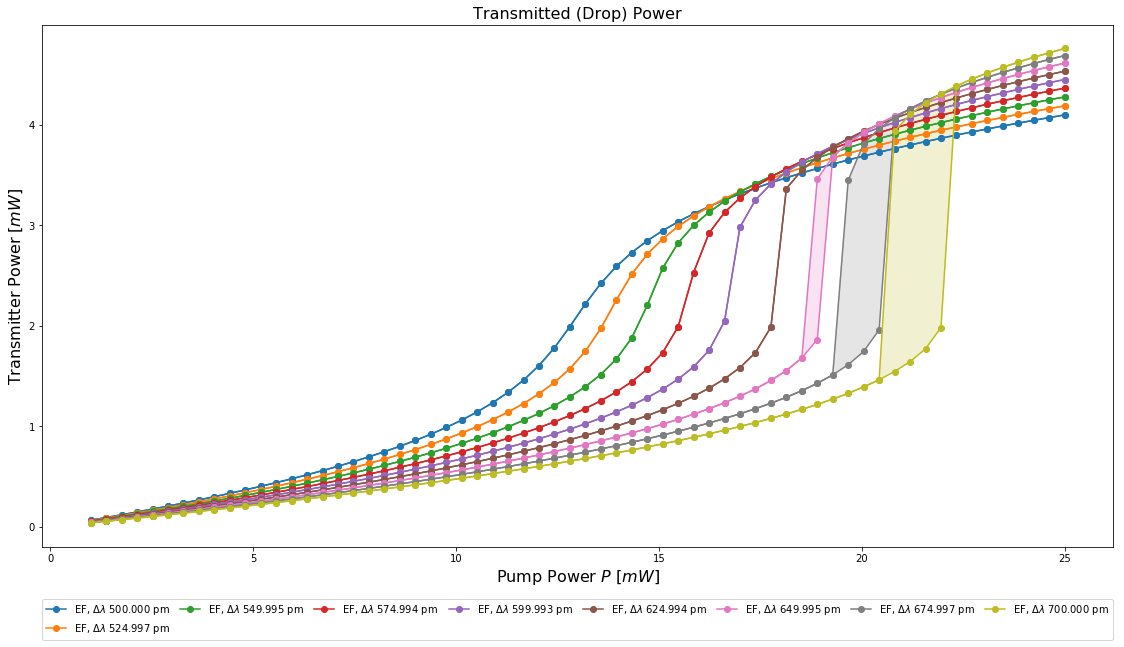

In [6]:
fig = plt.figure(figsize=(3*6.4, 2*4.8)) # default = 6.4, 4.8
ax1 = fig.add_subplot(111)

#ax1.set_ylim([5e3, 7.5e4])
#ax1.set_xlim([1549, 1551])

ul = []
dl = []
for ω_i in range(ω_size):
    #if E_i <= 3:
        #ax1.plot(E_range[:], np.abs(d['Up'][ω_i,:,0])**2, label='Up, $\lambda$ %.3f nm'%(1e9*f2w(ω_range[ω_i]*ω0,)), ls='-', marker='o')
        ul.append(
            ax1.plot(ñwga*I_range, κ**2*P_range*𝛾*u['Δ𝛾'][ω_i,:,0]*u['EF'][ω_i,:,0], ls='-', marker='o',
                     label='EF, $\Delta\lambda$ %.3f pm'%(1e3*(1e9*f2w(ω_range[ω_i]/(2*np.pi)*f0,)-1e3*λ_res)),
                    )
        )
        dl.append(
            ax1.plot(ñwga*I_range, κ**2*P_range*𝛾*d['Δ𝛾'][ω_i,:,0]*d['EF'][ω_i,:,0], ls='-', marker='o', color=ul[-1][0].get_color() )
        )
        plup = κ**2*P_range*𝛾*u['Δ𝛾'][ω_i,:,0]*u['EF'][ω_i,:,0]
        pldo = κ**2*P_range*𝛾*d['Δ𝛾'][ω_i,:,0]*d['EF'][ω_i,:,0]
        ax1.fill_between(ñwga*I_range, pldo, plup, where=pldo>=plup, interpolate=True, color=ul[-1][0].get_color(), alpha=0.2)

ax1.set_title( r'Transmitted (Drop) Power', fontsize=16)
ax1.set_xlabel(r'Pump Power $P$ $[mW]$', fontsize=16)
ax1.set_ylabel(r'Transmitter Power [$mW$]', fontsize=16)

legend = ax1.legend(bbox_to_anchor=(0., -.05, 1., -.05), loc=2, ncol=8, mode="expand", borderaxespad=0.)

#tikz_save('test.tex')

plt.show()
plt.close()

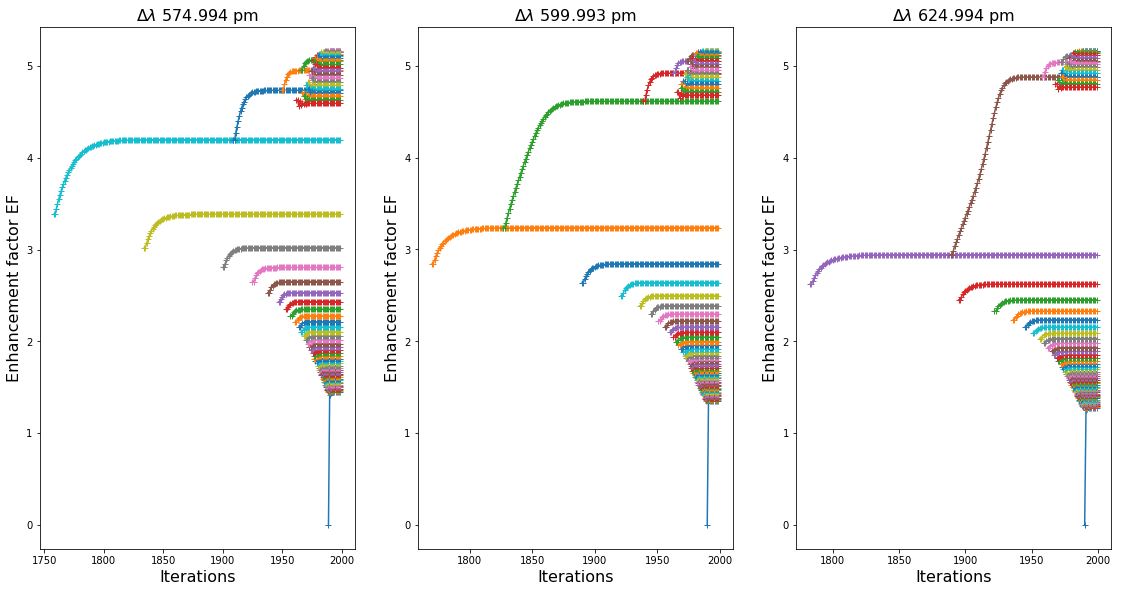

In [7]:
fig = plt.figure(figsize=(3*6.4, 2*4.8)) # default = 6.4, 4.8

ax1 = fig.add_subplot(131)
ax1.plot(u['EF'][3,:,::-1].T, ls='-', marker='+')
ax1.set_title( r'$\Delta\lambda$ %.3f pm'%(1e3*(1e9*f2w(ω_range[3]/(2*np.pi)*f0,)-1e3*λ_res)), fontsize=16)
ax1.set_xlabel(r'Iterations', fontsize=16)
ax1.set_ylabel(r'Enhancement factor EF', fontsize=16)

ax2 = fig.add_subplot(132)
ax2.plot(u['EF'][4,:,::-1].T, ls='-', marker='+')
ax2.set_title( r'$\Delta\lambda$ %.3f pm'%(1e3*(1e9*f2w(ω_range[4]/(2*np.pi)*f0,)-1e3*λ_res)), fontsize=16)
ax2.set_xlabel(r'Iterations', fontsize=16)
ax2.set_ylabel(r'Enhancement factor EF', fontsize=16)

ax3 = fig.add_subplot(133)
ax3.plot(u['EF'][5,:,::-1].T, ls='-', marker='+')
ax3.set_title( r'$\Delta\lambda$ %.3f pm'%(1e3*(1e9*f2w(ω_range[5]/(2*np.pi)*f0,)-1e3*λ_res)), fontsize=16)
ax3.set_xlabel(r'Iterations', fontsize=16)
ax3.set_ylabel(r'Enhancement factor EF', fontsize=16)
#label='EF, $\Delta\lambda$ %.3f pm'%(1e3*(1e9*f2w(ω_range[ω_i]/(2*np.pi)*f0,)-1e3*λ_res)),

#legend = ax1.legend(bbox_to_anchor=(0., -.05, 1., -.05), loc=2, ncol=8, mode="expand", borderaxespad=0.)

plt.show()
plt.close()

In [13]:
### save data to csv files
he = ['\t{:.0f}'.format( 1e12*f2w(1e15*x/(2*np.pi)) - 1e6*λ_res) for x in ω_range ]
ω_range  = 2*np.pi*np.linspace(w2f(1e-6*λ_res+.5e-9), w2f(1e-6*λ_res+.7e-9), ω_size)/f0 # [Hz/ω0]
head = 'Power'
for x in he:
    head += x
print(head)

ics = P_range.reshape(np.size(P_range),1)
print(ics[:10],'\n...\n',ics[-10:])
print(ics.shape)

### upwards
print( ( κ**2*𝛾*P_range*u['Δ𝛾'][:,:,0]*u['EF'][:,:,0] ).T.shape )
dat = np.concatenate( (ics, (κ**2*𝛾*P_range*u['Δ𝛾'][:,:,0]*u['EF'][:,:,0]).T), axis=1 )
print(dat.shape)

np.savetxt("upwards.csv", dat, fmt='%.8e', delimiter="\t", header=head, comments='')

### downwards
print( ( κ**2*𝛾*P_range*d['Δ𝛾'][:,:,0]*d['EF'][:,:,0] ).T.shape )
dat = np.concatenate( (ics, (κ**2*𝛾*P_range*d['Δ𝛾'][:,:,0]*d['EF'][:,:,0]).T), axis=1 )
print(dat.shape)

np.savetxt("downwards.csv", dat, fmt='%.8e', delimiter="\t", header=head, comments='')

Power	500	525	550	575	600	625	650	675	700
[[1.        ]
 [1.38095238]
 [1.76190476]
 [2.14285714]
 [2.52380952]
 [2.9047619 ]
 [3.28571429]
 [3.66666667]
 [4.04761905]
 [4.42857143]] 
...
 [[21.57142857]
 [21.95238095]
 [22.33333333]
 [22.71428571]
 [23.0952381 ]
 [23.47619048]
 [23.85714286]
 [24.23809524]
 [24.61904762]
 [25.        ]]
(64, 1)
(64, 9)
(64, 10)
(64, 9)
(64, 10)


In [9]:
##dl = 1e12*f2w(ω_range*ω0) - 1.55e6
#dl = (1e12*f2w(ω_range*ω0) - 1.55e6).reshape(np.size(ω_range),1)
#dat = u['Ut'][:,:,0]
#datt = np.concatenate( ((ñwga*E_range**2).reshape(np.size(E_range),1).T, dat), axis=0 )
#print( np.shape(datt) )
#
#dll = (1e12*f2w(ω_range*ω0) - 1.55e6).reshape(np.size(ω_range),1)
#dll2 = ['\t%d'%x for x in np.around(dll) ]
#dll3 = 'Power'
#for x in dll2:
#    dll3 += x
#print(dll3)
#print()
#print( datt[:4,-12:].T )
#
#np.savetxt("upwards.csv", datt.T, fmt='%.8e', delimiter="\t", header=dll3, comments='')#, newline=' \\')
#
#dat = d['Ut'][:,:,0]
#datt = np.concatenate( ((ñwga*E_range**2).reshape(np.size(E_range),1).T, dat), axis=0 )
#
#np.savetxt("downwards.csv", datt.T, fmt='%.8e', delimiter="\t", header=dll3, comments='')#, newline=' \\')

In [10]:
#linear = True
#
#fig = plt.figure(figsize=(3*6.4, 2*4.8)) # default = 6.4, 4.8
#ax1 = fig.add_subplot(111)
#
#if not linear:
#    ax1.set_yscale('log')
#    ax1.set_ylim([1e-20, 1e-2])
#
#for ω_i in range(ω_size):
#    #if E_i <= 3:
#        ax1.plot(ñwga*E_range**2, u['Ut'][ω_i,:,0]-u['Ut'][ω_i,:,2], label='Uint, $\lambda$ %.3f nm'%(1e9*f2w(ω_range[ω_i]*ω0,)))
#        ax1.plot(ñwga*E_range**2, u['Ut'][ω_i,:,1]-u['Ut'][ω_i,:,3], label='Uint, $\lambda$ %.3f nm'%(1e9*f2w(ω_range[ω_i]*ω0,)), ls='--')
#
#ax1.set_title( r'Total Internal Power', fontsize=16)
#ax1.set_xlabel(r'Pump Power $P$ $[mW]$', fontsize=16)
#ax1.set_ylabel(r'Internal Power $[$not exactly $a.u.]$', fontsize=16)
#
#legend = ax1.legend(bbox_to_anchor=(0., -0.05, 1., -0.05), loc=2, ncol=8, mode="expand", borderaxespad=0.)
#
#plt.show()
#plt.close()

In [11]:
#linear = True

#fig = plt.figure(figsize=(3*6.4, 2*4.8)) # default = 6.4, 4.8
#ax1 = fig.add_subplot(111)

#if not linear:
#    ax1.set_yscale('log')
#    ax1.set_ylim([1e-20, 1e-2])  

#if 0:
#    for ω_i in range(ω_size):
#        ax1.plot(ñwga*E_range**2, u['ΔN'][ω_i,:,0], label='ΔN, $\lambda$ %.3f mW'%(1e9*f2w(ω_range[ω_i]*ω0,)))
#    ax1.set_title( r'Population Variation', fontsize=16)
#    ax1.set_ylabel(r'Population Variation ΔN $[a.u.]$', fontsize=16)

#if 0:
#    for ω_i in range(ω_size):
#        ax1.plot(ñwga*E_range**2, u['ΔT'][ω_i,:,0], label='ΔT, $\lambda$ %.3f mW'%(1e9*f2w(ω_range[ω_i]*ω0,)))
#    ax1.set_title( r'Temperature Variation', fontsize=16)
#    ax1.set_ylabel(r'Temperature Variation ΔT $[K]$', fontsize=16)

#if 1:
#    ax2 = ax1.twinx()
#    for ω_i in range(ω_size):
#        ax2.plot(ñwga*E_range**2, np.real(u['Δω'][ω_i,:,0])/ω0, label='RE[Δω], $\lambda$ %.3f mW'%(1e9*f2w(ω_range[ω_i]*ω0,)))
##        ax2.plot(E_range, np.imag(u['Δω'][ω_i,:,0])/ω0, label='IM[Δω], $\lambda$ %.3f mW'%(1e9*f2w(ω_range[ω_i]*ω0,)), ls='--')
#    #ax2.set_title( r'Resonance Wavelength Variation', fontsize=16)
#    ax2.set_title( r'Physical Quantities Variation', fontsize=16)
#    ax2.set_ylabel(r'Resonance Wavelength Variation Δω $[nm]$', fontsize=16)
#    
##ax2.set_ylabel('sin', color='r')
##ax2.tick_params('y', colors='r')
#
#ax1.set_xlabel(r'Pump Power $P$ $[mW]$', fontsize=16)
#
##legend = ax1.legend(bbox_to_anchor=(0., -.05, 1., -.05), loc=2, ncol=8, mode="expand", borderaxespad=0.)
#
#plt.show()
#plt.close()

In [12]:
#from mpl_toolkits.mplot3d import Axes3D
#
#fig = plt.figure(figsize=(3*6.4, 2*4.8)) # default = 6.4, 4.8
#ax1 = fig.add_subplot(111, projection='3d')
#
#ax1.set_title( r'Internal Power', fontsize=16)
#
##λv, Pv = np.meshgrid( 1e12*f2w(ω_range*ω0)-1.55e6, E_range)
#
##ax1.plot_surface(λv, Pv, u['Ut'][:,:,0].T)
#
#ul = []
#dl = []
#for ω_i in range(ω_size):
#    ul.append(
#        ax1.plot(E_range*0+1e12*f2w(ω_range[ω_i]*ω0)-1.55e6, ñwga*E_range**2, u['Ut'][ω_i,:,0], ls='-', marker='o',
#                 label='Uint, $\lambda$ %.3f nm'%(1e9*f2w(ω_range[ω_i]*ω0,)),
#                )
#    )
#    dl.append(
#        ax1.plot(E_range*0+1e12*f2w(ω_range[ω_i]*ω0)-1.55e6, ñwga*E_range**2, d['Ut'][ω_i,:,0], ls='-', marker='o', color=ul[-1][0].get_color() )
#    ) 
#
#ax1.set_xlabel(r'Wavelength $\lambda$ $[nm]$', fontsize=16)
#ax1.set_ylabel(r'Pump Power $P$ $[mW]$', fontsize=16)
#ax1.set_zlabel(r'Internal Power [a.u.*]', fontsize=16)
#
#legend = ax1.legend(bbox_to_anchor=(0., -.05, 1., -.05), loc=2, ncol=8, mode="expand", borderaxespad=0.)
#
#plt.show()
#plt.close()